# NOTEBOOK DESCRIPTION

This Notebook implements a Binary Text Classifier for Tweets using a DeepLearning technique with Tensorflow. The aim of this work is to classify tweets related to the USA elections 2020 to predict if a given tweet is in favor of Trump or Biden. 

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split

import os

import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize   
from nltk.corpus import stopwords

import re
import emoji
import string

print(tf.__version__)

2.3.1


# CONSTANTS

In [2]:
def train_test_val_paths(path):
    """
    Creates a train, test and validation path from a given path
    by adding train_standarized_ , test_standarized_ and 
    validation_standarized_ 
    
    Example
    -------
    
    >>> train_test_val_paths('./input/hashtag_donaldtrump.csv')
    
    >>> ('./input/train_standarized_hashtag_donaldtrump.csv',
         './input/test_standarized_hashtag_donaldtrump.csv',
         './input/val_standarized_hashtag_donaldtrump.csv')
    """
    
    # Get directory and filename
    dirname = os.path.dirname(path)
    basename = os.path.basename(path)
    
    # Create path for each dataset
    train_path = os.path.join(dirname, 'train_standarized_' + basename)
    test_path = os.path.join(dirname, 'test_standarized_' + basename)
    val_path = os.path.join(dirname, 'val_standarized_' + basename)
    
    return train_path, test_path, val_path

In [3]:
BATCH_SIZE= 1000
TEST_SIZE = 0.15 
VAL_SIZE= 0.15

trump_path = './input/hashtag_donaldtrump.csv'
biden_path = './input/hashtag_joebiden.csv'

train_trump, test_trump, val_trump = train_test_val_paths(trump_path)
train_biden, test_biden, val_biden = train_test_val_paths(biden_path)

# TRAIN - TEST SPLIT

In [4]:
def custom_standardization(text):
    """
    Standardize a tensor of strings by applying the 
    following rules:
        - Lower case the text.
        - Remove line breaks.
        - Remove URLs.
        - Remove emojis.
        - Remove punctuation.
    
    Return
    ------
    np.ndarray of decoded strings.
    
    """
    
    # Lower case
    lower_text = tf.strings.lower(text)

    # Remove line breaks
    lower_text = tf.strings.regex_replace(input=lower_text, 
                                          pattern='\n', 
                                          rewrite=' ')

    # Remove URLs
    free_url_text = tf.strings.regex_replace(input=lower_text, 
                                             pattern="http\S+", 
                                             rewrite=' ')

    # Remove emojis
    emoji_pattern = emoji.get_emoji_regexp().pattern
    emoji_pattern = emoji_pattern.replace('#','') # There is a # emoji
    free_emoji_text = tf.strings.regex_replace(input=free_url_text, 
                                               pattern='[%s]' % re.escape(emoji_pattern),
                                               rewrite=' ')

    # Remove punctuation
    # punctuation_pattern = string.punctuation.replace('#', '').replace('@','').replace("\'", '')
    punctuation_pattern = string.punctuation
    free_punctuation_text =  tf.strings.regex_replace(free_emoji_text,
                                                      '[%s]' % re.escape(punctuation_pattern),
                                                      ' ')
    return free_punctuation_text.numpy().decode()


In [5]:
#
# Original function in: https://www.kaggle.com/gatandubuc/donald-trump-vs-joe-biden
#
def is_english(text):
    """
    Calculate probability of given text to be written in several languages and
    return a dictionary that looks like {'french': 2, 'spanish': 4, 'english': 0}
    
    @param text: Text whose language want to be detected
    @type text: str
    
    @return: Dictionary with languages and unique stopwords seen in analyzed text
    @rtype: dict
    """

    languages_ratios = {}

    '''
    nltk.wordpunct_tokenize() splits all punctuations into separate tokens
    
    >>> wordpunct_tokenize("That's thirty minutes away. I'll be there in ten.")
    ['That', "'", 's', 'thirty', 'minutes', 'away', '.', 'I', "'", 'll', 'be', 'there', 'in', 'ten', '.']
    '''
    
    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    # Compute per language included in nltk number of unique stopwords appearing in analyzed text
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)

        languages_ratios[language] = len(common_elements) # language "score"
    
    most_rated_language = max(languages_ratios, key=languages_ratios.get)
      
    return most_rated_language == 'english'

In [6]:
def get_tweets_split(path):
    """
    Load a CSV file from the path indicated by parameter
    and split the data in train, test and validation CSV files
    standardizing and filtering it by language the content.
    
    """
    
    train_path, test_path, val_path = train_test_val_paths(path)
    
    # Create an empty csv file to append chunks
    header_df = pd.DataFrame(columns=['tweet'])
    header_df.to_csv(train_path, index=False)
    header_df.to_csv(test_path, index=False)
    header_df.to_csv(val_path, index=False)
    
    # Define the probabilities to select each path
    TRAIN_SIZE = 1 - TEST_SIZE - VAL_SIZE
    probabilities = [TRAIN_SIZE, TEST_SIZE, VAL_SIZE]
    paths = [train_path, test_path, val_path]
    
    # Create the DataFrame Reader
    df = pd.read_csv(path, 
                     lineterminator='\n', 
                     chunksize=BATCH_SIZE, 
                     usecols=['tweet'])

    # Split the dataset
    for chunk in df:
        # Standarized tweets
        chunk['tweet'] = chunk['tweet'].apply(custom_standardization)
        
        # Remove not english tweets
        chunk = chunk[chunk['tweet'].map(is_english)]
        
        # Select a path
        path = np.random.choice(paths, p=probabilities)
        
        # Save
        chunk.to_csv(path, index=False, mode='a', header=False)


In [7]:
# get_tweets_split(path=trump_path)
# get_tweets_split(path=biden_path)

# SHUFFLE DATA

In [8]:
def shuffle_data(train_path, val_path, test_path):
    """
    Combine the train, validation and test CSV files specified 
    by parameter, shuffle them and split them again.
    
    """
    
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    concat_df = pd.concat([train_df, val_df, test_df])

    train_df, test_df = train_test_split(concat_df, test_size=TEST_SIZE)
    train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE)

    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    test_df.to_csv(test_path, index=False)

In [9]:
# shuffle_data(train_trump, val_trump, test_trump)
# shuffle_data(train_biden, val_biden, test_biden)

# INPUT PIPELINE

In [7]:
def create_dataset(path):
    """
    Create a tf.data.Dataset from a CSV file using the
    tweet column of the CSV file.
    
    """
    
    # Create the dataset
    ds = tf.data.experimental.make_csv_dataset(path, 
                                              batch_size=BATCH_SIZE, 
                                              select_columns=['tweet'],
                                              num_epochs=1)
    # Get the data in the tweet column
    ds = ds.map(lambda x: x['tweet'])

    return ds

In [8]:
def add_class_column(dataset, class_value):
    return dataset.map(lambda x: (x, tf.repeat(class_value, tf.size(x))))

In [9]:
def input_pipeline(trump_path, biden_path, class_atributte=True):
    """
    Creates a tf.data.Dataset combining tweets from the two
    CSV files specified by parameter.
    
    """
    
    trump_ds = create_dataset(trump_path)
    biden_ds = create_dataset(biden_path)
    
    # Add class atributte
    if class_atributte:
        trump_ds = add_class_column(trump_ds, 0)
        biden_ds = add_class_column(biden_ds, 1)
    
    datasets = [
        trump_ds.unbatch(),
        biden_ds.unbatch()
    ]
    
    # Equally merge datasets
    trump_biden_ds = tf.data.experimental.sample_from_datasets(datasets=datasets, weights=[0.5, 0.5], seed=42)
        
    # Batch the dataset
    trump_biden_ds = trump_biden_ds.batch(BATCH_SIZE)
    
    return trump_biden_ds
    

In [10]:
train_ds = input_pipeline(train_trump, train_biden, class_atributte=True)
val_ds = input_pipeline(val_trump, val_biden, class_atributte=True)
test_ds = input_pipeline(test_trump, test_biden, class_atributte=True)

In [56]:
features, labels = next(iter(train_ds))
print(features[:2])
print(labels[:20])

tf.Tensor(
[b'joe biden to visit iowa  releases ads to inspire latino voters  thesource  joebiden  '
 b'critical  pa  swing state  voters what they think about  biden flipflop and favouring  trump     '], shape=(2,), dtype=string)
tf.Tensor([1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0], shape=(20,), dtype=int32)


(array([172., 278., 221., 300.,  28.,   0.,   0.,   0.,   0.,   1.]),
 array([ 17. ,  86.3, 155.6, 224.9, 294.2, 363.5, 432.8, 502.1, 571.4,
        640.7, 710. ]),
 <BarContainer object of 10 artists>)

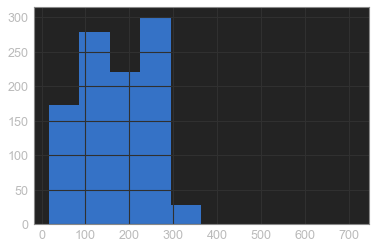

In [57]:
plt.hist(list(map(len,features.numpy())))

# MODEL

## Vectorize layer

### Define the layer

In [13]:
MAX_FEATURES = 5000
SEQUENCE_LENGTH = 260 

vectorize_layer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

### Adapt the layer

In [14]:
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

### Apply the layer

In [60]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [61]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

### Configure datasets for performance

In [62]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [63]:
EMBEDDING_DIM = 8

model = tf.keras.Sequential([
    
    layers.Embedding(
        input_dim=MAX_FEATURES + 1,
        output_dim=EMBEDDING_DIM,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    
    layers.Dropout(0.2),
    
    layers.Bidirectional(
        tf.keras.layers.LSTM(8, 
                             kernel_regularizer=regularizers.l2(0.0001)
                            )
    ),
    
    layers.Dense(8, 
                 kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'
                ),
    
    layers.Dropout(0.2),
    
    layers.Dense(1)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 8)           40008     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 8)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16)                1088      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_11 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 41,241
Trainable params: 41,241
Non-trainable params: 0
__________________________________________________

### Loss function and optimizer

In [64]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

In [65]:
def get_callbacks():
    return [
#         tfdocs.modeling.EpochDots(report_every=100),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
      ]

In [66]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/25
573/573 [==============================] - 756s 1s/step - loss: 0.3542 - binary_accuracy: 0.8350 - val_loss: 2.5521 - val_binary_accuracy: 0.6101
Epoch 2/25
573/573 [==============================] - 787s 1s/step - loss: 0.2770 - binary_accuracy: 0.8720 - val_loss: 1.7003 - val_binary_accuracy: 0.6322
Epoch 3/25
573/573 [==============================] - 788s 1s/step - loss: 0.2426 - binary_accuracy: 0.8767 - val_loss: 1.0769 - val_binary_accuracy: 0.6460
Epoch 4/25
573/573 [==============================] - 899s 2s/step - loss: 0.2304 - binary_accuracy: 0.8761 - val_loss: 0.9100 - val_binary_accuracy: 0.6510
Epoch 5/25
573/573 [==============================] - 852s 1s/step - loss: 0.2260 - binary_accuracy: 0.8767 - val_loss: 1.2858 - val_binary_accuracy: 0.6480
Epoch 6/25
573/573 [==============================] - 970s 2s/step - loss: 0.2281 - binary_accuracy: 0.8751 - val_loss: 0.7063 - val_binary_accuracy: 0.6738
Epoch 7/25
573/573 [==============================] - 877s

In [67]:
h = history.history

loss = h.get('loss')
binary_accuracy = h.get('binary_accuracy')
val_loss = h.get('val_loss')
val_binary_accuracy = h.get('val_binary_accuracy')

epochs = range(1, len(loss) + 1)

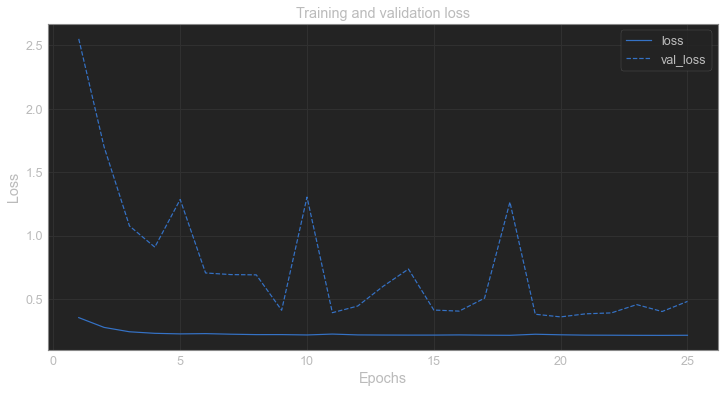

In [68]:
plt.figure(figsize=(12,6))

plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, '--b', label='val_loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

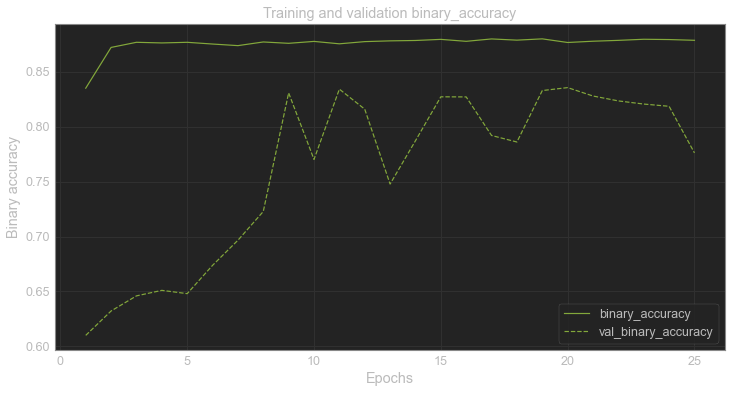

In [69]:
plt.figure(figsize=(12,6))

plt.plot(epochs, binary_accuracy, 'g', label='binary_accuracy')
plt.plot(epochs, val_binary_accuracy, '--g', label='val_binary_accuracy')

plt.title('Training and validation binary_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary accuracy')
plt.legend()

## Save the model

In [70]:
model.save('./saved_model/little_model')

INFO:tensorflow:Assets written to: ./saved_model/little_model\assets


## Restore the model

In [11]:
new_model = tf.keras.models.load_model('saved_model/little_model')

## Evaluate the model

In [72]:
new_model.evaluate(val_ds)

102/102 [==============================] - 33s 326ms/step - loss: 0.4819 - binary_accuracy: 0.7761


[0.48192480206489563, 0.7760853171348572]

In [73]:
new_model.evaluate(test_ds)

119/119 [==============================] - 39s 328ms/step - loss: 0.4809 - binary_accuracy: 0.7763


[0.48089149594306946, 0.776252269744873]

## Deployable model

In [15]:
deployable_model = tf.keras.Sequential([
    vectorize_layer,
    new_model,
])

deployable_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), 
    optimizer="adam", 
    metrics=['accuracy']
)


In [16]:
# Recreate the input pipeline to avoid using TextVectorization layers
# in datasets.

train_ds = input_pipeline(train_trump, train_biden, class_atributte=True)
val_ds = input_pipeline(val_trump, val_biden, class_atributte=True)
test_ds = input_pipeline(test_trump, test_biden, class_atributte=True)

#### IMPORANT: it's necessary evaluate or test the deployable model before save to stablish the input shape

In [17]:
deployable_model.evaluate(val_ds)

102/102 [==============================] - 18s 173ms/step - loss: 3.4622 - accuracy: 0.7738


[3.462167739868164, 0.7737609148025513]

In [18]:
deployable_model.evaluate(test_ds)

119/119 [==============================] - 24s 199ms/step - loss: 3.4597 - accuracy: 0.7738


[3.4597229957580566, 0.7737720608711243]

In [19]:
deployable_model.save('./saved_model/deployable_little_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_model/deployable_little_model\assets
